<a href="https://colab.research.google.com/github/smartdesignlab/SDL_teaching/blob/main/AE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# AE (AutoEncoder)

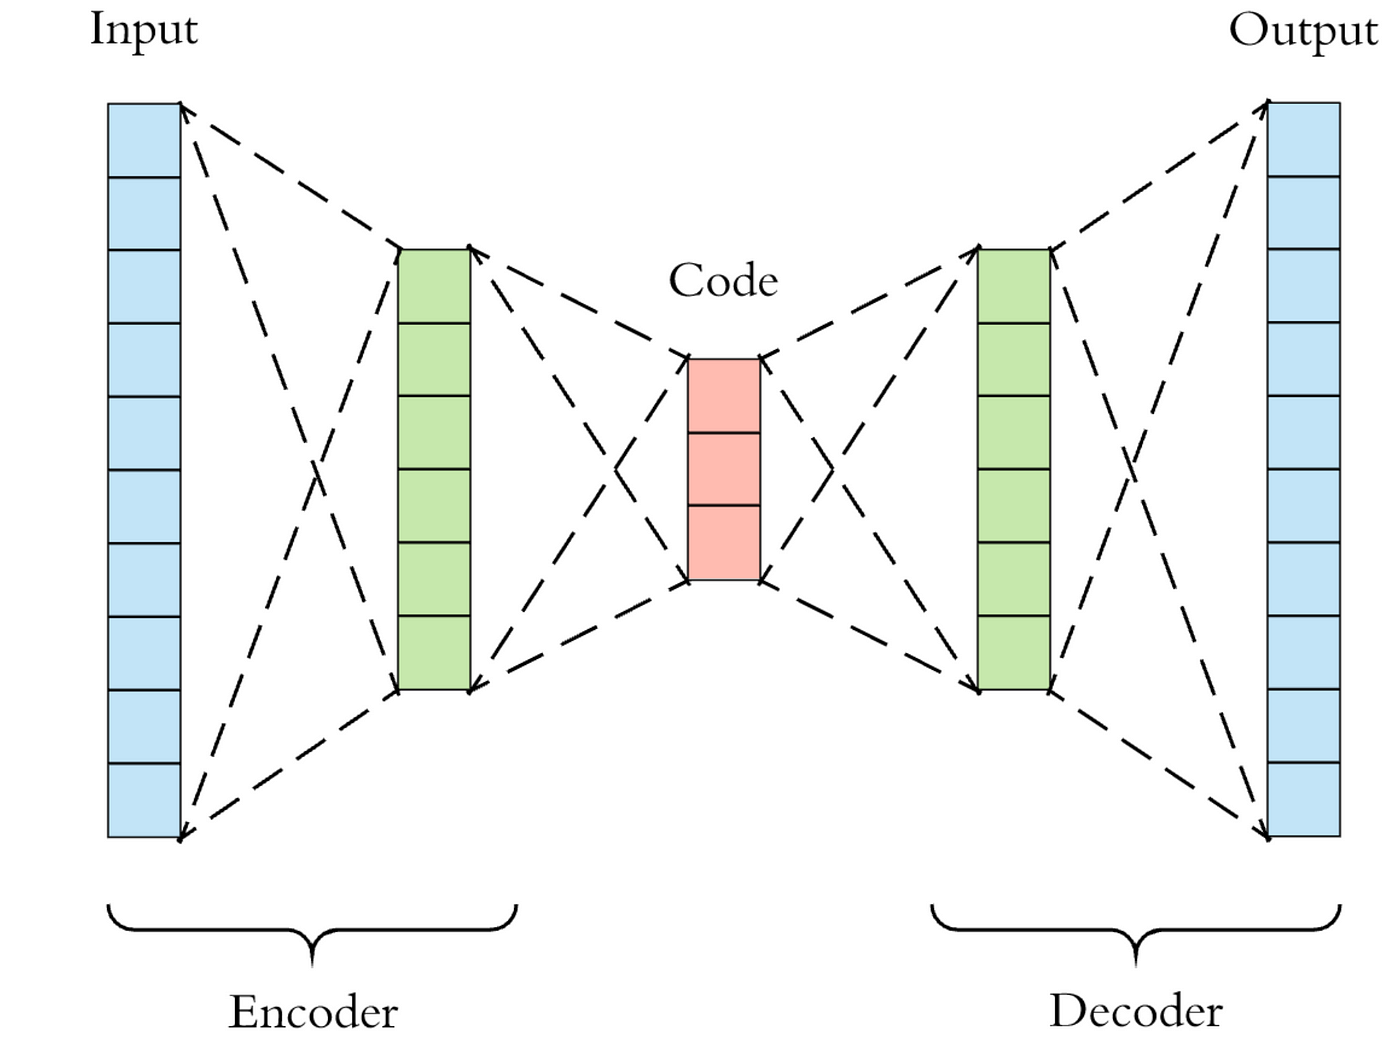

## 1. Load dataset

## 2. Import python libraries and define util functions

In [74]:
''' import '''
import numpy as np
import matplotlib.pyplot as plt
import os

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torchsummary import summary

from sklearn.model_selection import train_test_split
from sklearn.manifold import TSNE

from utils import get_device, get_data_model_path, set_seed, img_read, img_read_plot, plot_loss

In [75]:
''' set '''
device = get_device()
data_path, model_path = get_data_model_path(os.getcwd())
set_seed(0)

device, data_path, model_path

(device(type='cuda'),
 'd:\\workspace\\study\\DL2\\dataset',
 'd:\\workspace\\study\\DL2\\model')

## 3. Check dataset

## 4. Convert images into trainable data

In [76]:
''' load data '''
src = os.path.join(data_path, 'data_3000')
files = os.listdir(src)


X,Y = [],[]

for file in files:
    X.append(img_read(src, file) / 255.0)   # normalize
    Y.append(float(file[:-4]))              # label -> file name

X = np.array(X)
Y = np.array(Y)

print('X.shape:', X.shape)
print('Y.shape:', Y.shape)

X.shape: (3000, 56, 56)
Y.shape: (3000,)


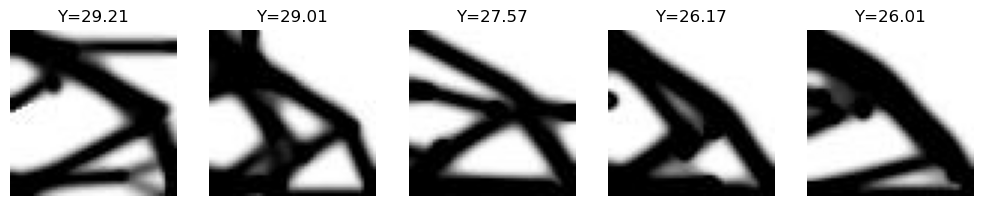

In [77]:
# check images
nplot = 5
idx = np.random.randint(1, 3000, nplot)

fig = plt.figure(figsize=(15,5))

for i in range(nplot):
    ax = fig.add_subplot(1, nplot+1, i+1)
    ax.imshow(X[idx[i],:,:], cmap='gray')
    ax.set_title(f"Y={Y[idx[i]]:.2f}")
    ax.axis('off')
plt.show()

## 5. Define dataloader

In [78]:
''' train test split '''
X_tr, X_ts, Y_tr, Y_ts = train_test_split(X,Y, test_size=0.2, random_state=1, shuffle=True)

print(X_tr.shape, X_ts.shape, Y_tr.shape,Y_ts.shape)


# reshape (flatten)
X_tr = X_tr.reshape(-1, np.prod(X_tr.shape[1:])) # (2400, 56, 56) -> (2400, 56*56)
X_ts = X_ts.reshape(-1, np.prod(X_ts.shape[1:]))

print(X_tr.shape,X_ts.shape)


# convert to Tensor
X_tr = torch.tensor(X_tr, dtype=torch.float32).to(device)
Y_tr = torch.tensor(Y_tr, dtype=torch.float32)
X_ts = torch.tensor(X_ts, dtype=torch.float32).to(device)
Y_ts = torch.tensor(Y_ts, dtype=torch.float32)

(2400, 56, 56) (600, 56, 56) (2400,) (600,)
(2400, 3136) (600, 3136)


## 6. Set to model architecture

In [79]:
''' model '''
class Autoencoder(nn.Module):
    def __init__(self, enc_fts, dec_fts=None):
        super(Autoencoder, self).__init__()

        if enc_fts is None:
            dec_fts = enc_fts[::-1]

        # enc_fts=[3136, 512, 256, 20], dec_fts=[20, 256, 512, 3136]

        # encoder
        self.encoder = nn.ModuleList()
        in_ft = enc_fts[0]

        for i in range(len(enc_fts)-2): # relu o
            out_ft = enc_fts[i+1]
            self.encoder.append(nn.Linear(in_ft, out_ft))
            self.encoder.append(nn.ReLU())
            in_ft = out_ft
        
        out_ft = enc_fts[-1] # relu x
        self.encoder.append(nn.Linear(in_ft, out_ft))
        
        # decoder
        self.decoder = nn.ModuleList()
        in_ft = out_ft # dec_fts[0]

        for i in range(len(dec_fts)-1): # relu o
            out_ft = dec_fts[i+1]
            self.decoder.append(nn.Linear(in_ft, out_ft))
            self.decoder.append(nn.ReLU())
            in_ft = out_ft

        out_ft = dec_fts[-1] # relu x
        self.decoder.append(nn.Linear(in_ft, out_ft))


    def forward(self, x):
        for layer in self.encoder:
            x = layer(x)
        for layer in self.decoder:
            x = layer(x)
        return x

In [80]:
# # input : 3136
# # h1 : 512
# # h2 : 20

# ''' model '''
# class Autoencoder(nn.Module):
#     def __init__(self):
#         super(Autoencoder, self).__init__()

        

#         self.encoder = nn.Sequential(
#             nn.Linear(3136, 512),
#             nn.ReLU(),
#             nn.Linear(512, 20),
#             nn.ReLU())

#         self.decoder = nn. Sequential(
#             nn.Linear(20, 512),
#             nn.ReLU(),
#             nn.Linear(512, 3136),
#             nn.ReLU())

#     def forward(self, x):
#         encoded = self.encoder(x)
#         decoded = self.decoder(encoded)

#         return decoded

In [81]:
# plot model
ae = Autoencoder(enc_fts=[56*56, 512, 256, 20], dec_fts=[20, 256, 512, 56*56]).to(device)

summary(ae, (3136,))  # input shape: (height*width, )
ae

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [-1, 512]       1,606,144
              ReLU-2                  [-1, 512]               0
            Linear-3                  [-1, 256]         131,328
              ReLU-4                  [-1, 256]               0
            Linear-5                   [-1, 20]           5,140
            Linear-6                  [-1, 256]           5,376
              ReLU-7                  [-1, 256]               0
            Linear-8                  [-1, 512]         131,584
              ReLU-9                  [-1, 512]               0
           Linear-10                 [-1, 3136]       1,608,768
             ReLU-11                 [-1, 3136]               0
           Linear-12                 [-1, 3136]       9,837,632
Total params: 13,325,972
Trainable params: 13,325,972
Non-trainable params: 0
-------------------------

Autoencoder(
  (encoder): ModuleList(
    (0): Linear(in_features=3136, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=256, bias=True)
    (3): ReLU()
    (4): Linear(in_features=256, out_features=20, bias=True)
  )
  (decoder): ModuleList(
    (0): Linear(in_features=20, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=3136, bias=True)
    (5): ReLU()
    (6): Linear(in_features=3136, out_features=3136, bias=True)
  )
)

## 7. Set model hyperparameters

In [82]:
''' hyper params '''
num_epochs = 300
batch_size = 64
learning_rate = 1e-3

''' loss, optim '''
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(params=ae.parameters(), lr=learning_rate)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer=optimizer, step_size=100, gamma=0.9)

In [83]:
''' dataloader '''
train_dataset = TensorDataset(X_tr, X_tr)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)   # iter마다 batch 반환

## 8. Train model

Epoch [ 1/300], Train loss: 0.11993


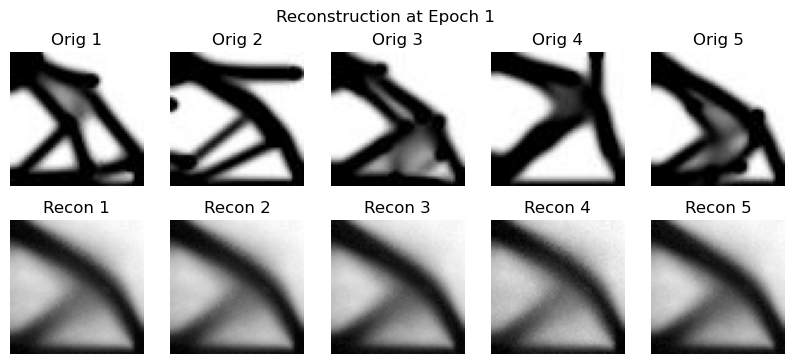

Epoch [ 2/300], Train loss: 0.08169
Epoch [ 3/300], Train loss: 0.06279
Epoch [ 4/300], Train loss: 0.05212
Epoch [ 5/300], Train loss: 0.04541
Epoch [ 6/300], Train loss: 0.03972
Epoch [ 7/300], Train loss: 0.03602
Epoch [ 8/300], Train loss: 0.03370
Epoch [ 9/300], Train loss: 0.03139
Epoch [10/300], Train loss: 0.02940
Epoch [11/300], Train loss: 0.02750
Epoch [12/300], Train loss: 0.02578
Epoch [13/300], Train loss: 0.02447
Epoch [14/300], Train loss: 0.02326
Epoch [15/300], Train loss: 0.02185
Epoch [16/300], Train loss: 0.02087
Epoch [17/300], Train loss: 0.01985
Epoch [18/300], Train loss: 0.01920
Epoch [19/300], Train loss: 0.01834
Epoch [20/300], Train loss: 0.01771
Epoch [21/300], Train loss: 0.01700
Epoch [22/300], Train loss: 0.01641
Epoch [23/300], Train loss: 0.01612
Epoch [24/300], Train loss: 0.01546
Epoch [25/300], Train loss: 0.01471
Epoch [26/300], Train loss: 0.01423
Epoch [27/300], Train loss: 0.01373
Epoch [28/300], Train loss: 0.01323
Epoch [29/300], Train loss: 

KeyboardInterrupt: 

In [84]:
''' train '''
loss_tr_hist = []

for epoch in range(num_epochs):
    
    # training
    ae.train()
    total_loss = 0.0

    for x, _ in train_loader:
        optimizer.zero_grad()
        output = ae(x)
        loss = criterion(output, x)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
    
    avg_loss = total_loss / len(train_loader)

    # history
    loss_tr_hist.append(avg_loss)
    print(f"Epoch [{epoch+1:2}/{num_epochs}], Train loss: {avg_loss:.5f}")

    scheduler.step()
    

    # validation
    if epoch % 50 == 0:
        ae.eval()
        with torch.no_grad():
            n = 5  # num of img

            plt.figure(figsize=(10, 4))
            
            for i in range(n):

                orig_img = X_ts.cpu()[i].reshape(56,56)
                recon_img = ae(X_ts[i]).detach().cpu().reshape(56,56)      # detach() : grad 연산 그래프에서 분리,     cpu() : gpu->cpu 복사

                # original
                ax = plt.subplot(2, n, i+1)
                plt.imshow(orig_img, cmap="gray")
                plt.title(f"Orig {i+1}")
                ax.axis('off')

                # recon
                ax = plt.subplot(2, n, i+1+n)
                plt.imshow(recon_img, cmap="gray")
                plt.title(f"Recon {i+1}")
                ax.axis('off')

            plt.suptitle(f"Reconstruction at Epoch {epoch+1}")
            plt.show()
            ae.train()

# save model
torch.save(ae.state_dict(), os.path.join(model_path, 'AE_model.pth'))

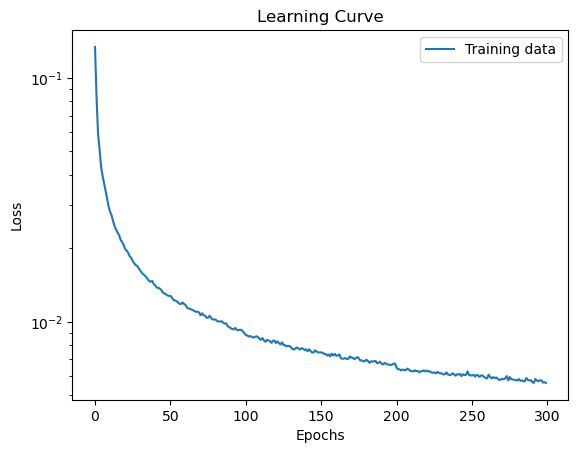

In [ ]:
# graph visualization
plot_loss(loss_tr_hist, logy=True, title='Learning Curve')
plt.show()

## 9. Load & Evaluate model

- Compare the orginial image and the reconstructed image

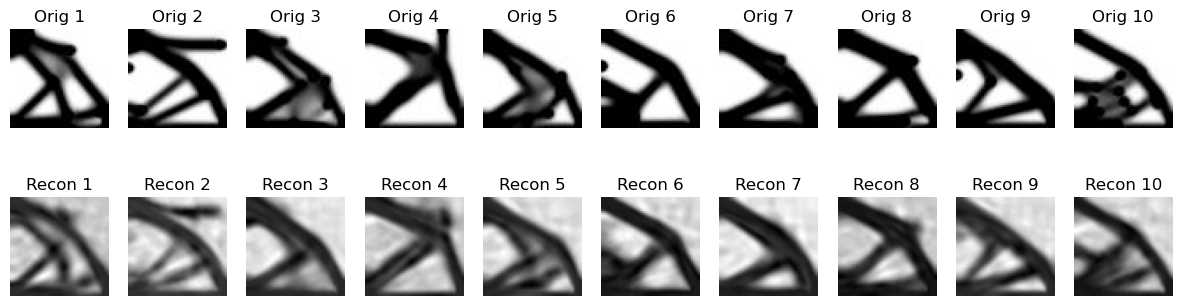

In [ ]:
''' evaluation '''
ae.eval()
n = 10

plt.figure(figsize=(15, 4))

for i in range(n):
    
    orig_img = X_ts.cpu()[i].reshape(56,56)
    recon_img = ae(X_ts[i]).detach().cpu().reshape(56,56)

    # original
    ax = plt.subplot(2, n, i+1)
    plt.imshow(orig_img, cmap="gray")
    plt.title(f"Orig {i+1}")
    ax.axis('off')

    # recon
    ax = plt.subplot(2, n, i+1+n)
    plt.imshow(recon_img, cmap="gray")
    plt.title(f"Recon {i+1}")
    ax.axis('off')

plt.show()

## 10. Visualize latent space using t-SNE (t-distributed Stochastic Neighbor Embedding)

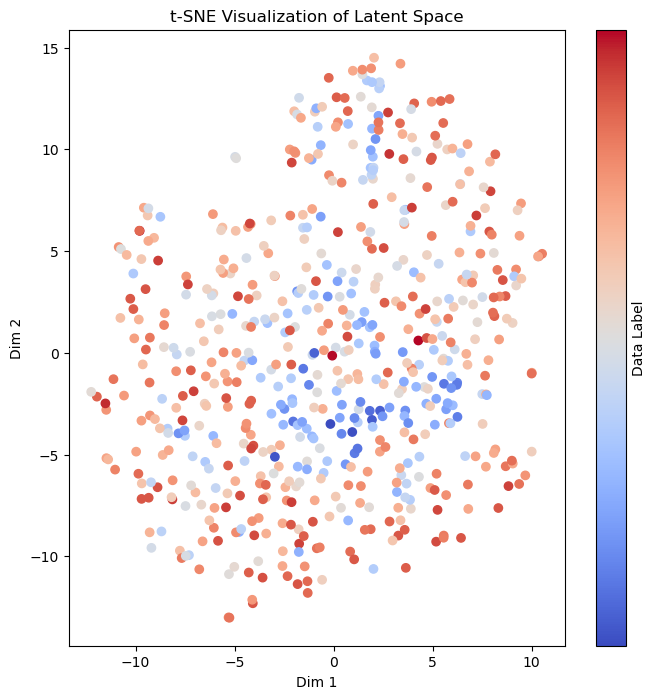

In [ ]:
''' visulaize latent space '''
ae.eval()
with torch.no_grad():
    z = X_ts
    for layer in ae.encoder:
        z = layer(z)
    z = z.squeeze().cpu().detach().numpy()   # latent space(z)

# dimension reduction (t-SNE)
tsne = TSNE(n_components=2, perplexity=70, random_state=0) # perplexity : num of neighbors
z_tsne = tsne.fit_transform(z)

# plot
plt.figure(figsize=(8, 8))
scatter = plt.scatter(z_tsne[:,0], z_tsne[:,1], c=Y_ts, cmap='coolwarm')

plt.colorbar(scatter, ticks=[0, 50], label='Data Label')
plt.xlabel("Dim 1")
plt.ylabel("Dim 2")
plt.title("t-SNE Visualization of Latent Space")
plt.show()